In [102]:
import iris
import iris.plot as iplt

import numpy
import matplotlib.pyplot as plt

from decimal import Decimal
import os, sys
cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)
import convenient_universal as uconv

In [103]:
%matplotlib inline

In [104]:
def calc_anomaly(cube):
    """Calculate the anomaly."""
    
    anomaly = cube.copy()
    anomaly.data = anomaly.data - anomaly.data[0]
    anomaly = anomaly[-1, ::]
    anomaly.remove_coord('time')
    
    return anomaly

In [105]:
def inferred_wfo(s_orig, s_new, volume):
    """Calculate the inferred cumulative global total wfo for a given change in soga.
    
    wfo = net water flux into sea water
    soga = global mean sea water salinity
    v = volume of ocean (m3)
    
    """
    
    p = 1027  # kg/m3; average density of global ocean - could calculate from rhopoto data
    m_globe = volume * p
    
    delta_m = -1 * m_globe * (1 - (s_orig / s_new))    
    
    return delta_m

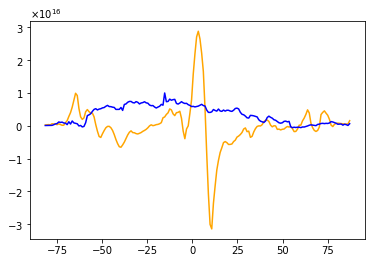

In [106]:
so_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/yr/ocean/r1i1p1/so/latest/dedrifted/so-vertical-zonal-mean_Oyr_CSIRO-Mk3-6-0_historical_r1i1p1_all.nc'
wfo_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/yr/ocean/r1i1p1/wfo/latest/dedrifted/wfo-zonal-sum_Oyr_CSIRO-Mk3-6-0_historical_r1i1p1_cumsum-all.nc'

wfo_cube = iris.load_cube(wfo_file)
so_cube = iris.load_cube(so_file)

volume_cube = iris.load_cube('/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/fx/ocean/r0i0p0/volcello/latest/volcello-vertical-sum_fx_CSIRO-Mk3-6-0_historical_r0i0p0.nc')
volume_zonal_sum = volume_cube.collapsed('longitude', iris.analysis.SUM)

wfo_anomaly = calc_anomaly(wfo_cube)
so_anomaly = wfo_anomaly.copy()
so_anomaly.data = inferred_wfo(so_cube[0, ::].data, so_cube[-1, ::].data, volume_zonal_sum.data)

iplt.plot(wfo_anomaly, color='orange', label='wfo')
iplt.plot(so_anomaly, color='blue', label='wfo')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
#ax.yaxis.major.formatter._useMathText = True

plt.show()

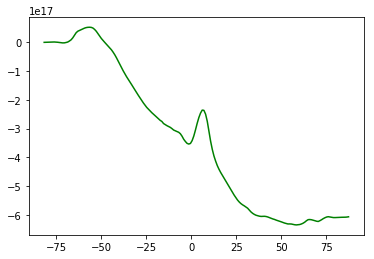

In [107]:
ocean_convergence = so_anomaly - wfo_anomaly
transport_inferred = ocean_convergence.copy()
transport_inferred.data = numpy.ma.cumsum(-1 * ocean_convergence.data)

iplt.plot(transport_inferred, color='green')

plt.show()

In [108]:
so_anomaly.data.sum()

6.184411531169178e+17

In [109]:
wfo_anomaly.data.sum()

1.1723307278691268e+16

In [110]:
volume_zonal_sum.data.sum()

1.3391146e+18

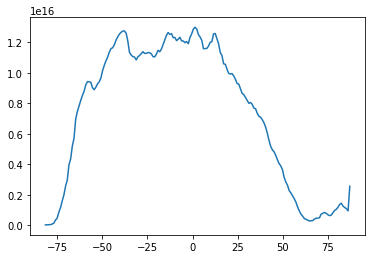

In [111]:
iplt.plot(volume_zonal_sum)

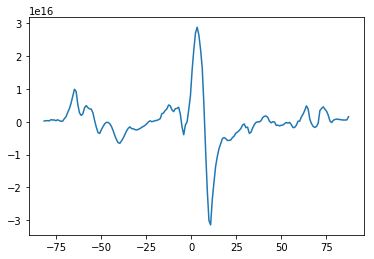

In [112]:
iplt.plot(wfo_anomaly)

In [113]:
soga_start = so_cube[0, ::].collapsed('latitude', iris.analysis.MEAN, weights=volume_zonal_sum.data).data
soga_end = so_cube[-1, ::].collapsed('latitude', iris.analysis.MEAN, weights=volume_zonal_sum.data).data
global_volume = volume_zonal_sum.data.sum()
#inferred_wfo(soga_start, soga_end, global_volume)

In [114]:
so_cube[-1, ::].collapsed('latitude', iris.analysis.MEAN, weights=volume_zonal_sum.data).data

array(34.71850342)

In [115]:
so_cube[0, ::].collapsed('latitude', iris.analysis.MEAN, weights=volume_zonal_sum.data).data

array(34.73411134)

In [116]:
wfo_globe_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/yr/ocean/r1i1p1/wfo/latest/dedrifted/wfo-globe-sum_Oyr_CSIRO-Mk3-6-0_historical_r1i1p1_cumsum-all.nc'
soga_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/yr/ocean/r1i1p1/soga/latest/dedrifted/soga_Oyr_CSIRO-Mk3-6-0_historical_r1i1p1_all.nc'

In [117]:
wfo_globe_cube = iris.load_cube(wfo_globe_file)

In [118]:
wfo_globe_cube.data[-1] - wfo_globe_cube.data[0]

1.1723130090848236e+16

In [119]:
soga_cube = iris.load_cube(soga_file)

In [120]:
soga_cube.data[0]

34.73411178588867

In [121]:
soga_cube.data[-1]

34.73387279723142

In [122]:
value = inferred_wfo(soga_cube.data[0], soga_cube.data[-1], global_volume)
'%.2E' % Decimal(value)


'9.46E+15'

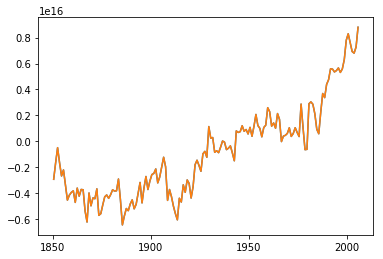

In [135]:
fig, ax = plt.subplots()
iplt.plot(wfo_globe_cube)

iplt.plot(wfo_cube.collapsed('latitude', iris.analysis.SUM))
plt.show()

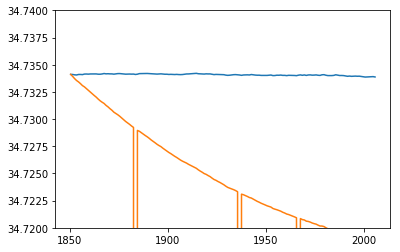

In [136]:
fig, ax = plt.subplots()
iplt.plot(soga_cube)

volume_weights = uconv.broadcast_array(volume_zonal_sum.data, 1, so_cube.shape)
iplt.plot(so_cube.collapsed('latitude', iris.analysis.MEAN, weights=volume_weights))
plt.ylim(34.72, 34.74)
ax.yaxis.major.formatter._useOffset = False
plt.show()

So the global wfo data I've calculated previously matches the sum of the zonally integrated wfo data.
The mean of the zonally integrated salinity data however is not equal to soga...

## Matching so and soga

In [152]:
raw_soga_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/yr/ocean/r1i1p1/soga/latest/soga_Oyr_CSIRO-Mk3-6-0_historical_r1i1p1_all.nc'
raw_soga_cube = iris.load_cube(raw_soga_file)

In [153]:
raw_vm_so_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/yr/ocean/r1i1p1/so/latest/so-vertical-mean_Oyr_CSIRO-Mk3-6-0_historical_r1i1p1_185001-185912.nc'
raw_vm_so_cube = iris.load_cube(raw_vm_so_file)

In [154]:
raw_vzm_so_file = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/yr/ocean/r1i1p1/so/latest/so-zonal-vertical-mean_Oyr_CSIRO-Mk3-6-0_historical_r1i1p1_all.nc'
raw_vzm_so_cube = iris.load_cube(raw_vzm_so_file)

In [155]:
volume_cube = iris.load_cube('/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historical/fx/ocean/r0i0p0/volcello/latest/volcello-vertical-sum_fx_CSIRO-Mk3-6-0_historical_r0i0p0.nc')

In [156]:
volume_vs_weights = uconv.broadcast_array(volume_cube.data, [1, 2], raw_vm_so_cube.shape)
inferred_vm_soga = raw_vm_so_cube.collapsed(['latitude', 'longitude'], iris.analysis.MEAN, weights=volume_vs_weights)

In [157]:
volume_vzs_cube = volume_cube.collapsed('longitude', iris.analysis.SUM)
volume_vzs_weights = uconv.broadcast_array(volume_vzs_cube.data, 1, raw_vzm_so_cube.shape)
inferred_vzm_soga = raw_vzm_so_cube.collapsed('latitude', iris.analysis.MEAN, weights=volume_vzs_weights)

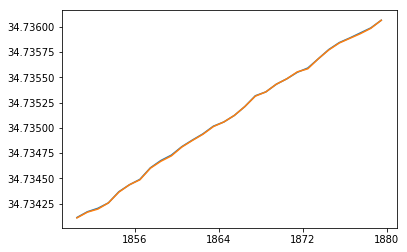

In [167]:
fig, ax = plt.subplots()
iplt.plot(raw_soga_cube[0:30])
#iplt.plot(inferred_vm_soga)
iplt.plot(inferred_vzm_soga[0:30])
ax.yaxis.major.formatter._useOffset = False
plt.show()

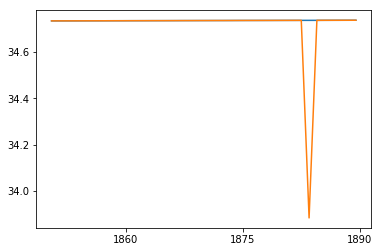

In [168]:
fig, ax = plt.subplots()
iplt.plot(raw_soga_cube[0:40])
#iplt.plot(inferred_vm_soga)
iplt.plot(inferred_vzm_soga[0:40])
ax.yaxis.major.formatter._useOffset = False
plt.show()

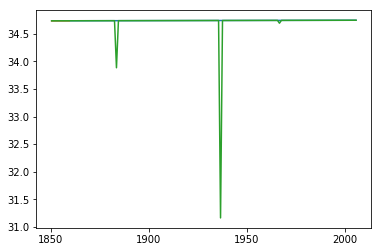

In [169]:
fig, ax = plt.subplots()
iplt.plot(raw_soga_cube)
iplt.plot(inferred_vm_soga)
iplt.plot(inferred_vzm_soga)
ax.yaxis.major.formatter._useOffset = False
plt.show()

So there doesn't appear to be a problem with how I'm integrating the salinity data (i.e. using volume weighted means).
The problem must therefore be with the dedrifting... In partcular, the drfited soga timeseries does not match the global sum of the dedrifted zonal mean salinity timeseries. It should. 

Perhaps the crazy values at some point are messing things up.